In [ ]:
pip install transformers torch sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 958.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Splits data into test and train data
def DataSplitter(data_loader):
    train_size = int(0.7 * len(data_loader))
    test_size = len(data_loader) - train_size
    train_dataset, test_dataset = random_split(data_loader, [train_size, test_size])

    print("Train size: " + str(len(train_dataset)))
    print("Test size: " + str(len(test_dataset)))
    print("[+] Training/Testing Set Split")

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_dataloader, test_dataloader, test_dataset

# Define the function to convert specific labels to group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, n_clusters=4):
        self.data = pd.read_csv(csv_file)

        # Prepare feature matrix X
        self.X = self.data.drop([self.data.columns[0], self.data.columns[1], self.data.columns[2]], axis=1).values

        # Standardize the features
        scaler = StandardScaler()
        self.X_scaled = scaler.fit_transform(self.X)

        # Fit K-means and get cluster labels
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = kmeans.fit_predict(self.X_scaled)

        # Prepare binary labels
        self.y_binary = self.data[self.data.columns[1]].values

        # Prepare specific labels
        self.y_specific = self.data[self.data.columns[2]].values

        # Prepare group labels
        self.y_group = self.data[self.data.columns[2]].apply(convert_to_group).values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Original features
        inputs = torch.tensor(self.X[idx], dtype=torch.float32)

        # K-means cluster label (converted to one-hot encoding)
        num_clusters = self.cluster_labels.max() + 1
        cluster_label = torch.zeros(num_clusters)
        cluster_label[self.cluster_labels[idx]] = 1.0

        # Concatenate original features with the one-hot encoded cluster label
        inputs_with_cluster = torch.cat((inputs, cluster_label), dim=0)

        binary_label = torch.tensor(self.y_binary[idx], dtype=torch.float32)
        group_label = torch.tensor(self.y_group[idx], dtype=torch.long)
        specific_label = torch.tensor(self.y_specific[idx], dtype=torch.long)

        return inputs_with_cluster, binary_label, group_label, specific_label


# Load dataset from disk
csv_file = '/content/drive/MyDrive/RansomwareData.csv'
dataset = CustomDataset(csv_file)

# Create DataLoader
train_loader, test_loader, test_dataset = DataSplitter(dataset)

# Test DataLoader
for batch in train_loader:
    inputs_with_clusters, binary_labels, group_labels, specific_labels = batch
    print("Inputs with Clusters:", inputs_with_clusters.shape)
    print("Binary Labels:", binary_labels.shape)
    print("Group Labels:", group_labels.shape)
    print("Specific Labels:", specific_labels.shape)
    break


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train size: 1066
Test size: 457
[+] Training/Testing Set Split
Inputs with Clusters: torch.Size([32, 30971])
Binary Labels: torch.Size([32])
Group Labels: torch.Size([32])
Specific Labels: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaConfig, RobertaModel

class BinaryFeatureEmbedding(nn.Module):
    def __init__(self, num_features, embed_dim):
        super(BinaryFeatureEmbedding, self).__init__()
        self.linear = nn.Linear(num_features, embed_dim)

    def forward(self, x):
        return self.linear(x)

class CustomRoBERTaModel(nn.Module):
    def __init__(self, num_features, embed_dim, num_groups, num_specific):
        super(CustomRoBERTaModel, self).__init__()

        self.embedding = BinaryFeatureEmbedding(num_features, embed_dim)

        config = RobertaConfig(
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            max_position_embeddings=num_features,
            type_vocab_size=2,
            initializer_range=0.02,
            layer_norm_eps=1e-12
        )

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout with probability 0.5

        self.binary_output = nn.Linear(embed_dim, 1)
        self.group_output = nn.Linear(embed_dim, num_groups)
        self.specific_output = nn.Linear(embed_dim, num_specific)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        outputs = self.roberta(inputs_embeds=x)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)  # Apply dropout to the output

        binary_logits = self.binary_output(cls_output)
        binary_probs = torch.sigmoid(binary_logits)

        group_logits = self.group_output(cls_output)
        group_probs = torch.softmax(group_logits, dim=-1)

        specific_logits = self.specific_output(cls_output)
        specific_probs = torch.softmax(specific_logits, dim=-1)

        return binary_probs, group_probs, specific_probs

# Sample usage
num_features = 30971
embed_dim = 768
num_groups = 5  # Adjusted based on earlier grouping structure
num_specific = 12

model = CustomRoBERTaModel(num_features, embed_dim, num_groups, num_specific)
sample_input = torch.randint(0, 2, (8, num_features)).float()  # batch_size=8, num_features=30964
binary_output, group_output, specific_output = model(sample_input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Binary output shape:", binary_output.shape)
print("Group output shape:", group_output.shape)
print("Specific output shape:", specific_output.shape)


Binary output shape: torch.Size([8, 1])
Group output shape: torch.Size([8, 5])
Specific output shape: torch.Size([8, 12])


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, data_loader, device):
    model.eval()
    binary_true = []
    binary_pred = []
    group_true = []
    group_pred = []
    specific_true = []
    specific_pred = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, binary_labels, group_labels, specific_labels = batch
            inputs = inputs.to(device)
            binary_labels = binary_labels.to(device)
            group_labels = group_labels.to(device)
            specific_labels = specific_labels.to(device)
            binary_probs, group_probs, specific_probs = model(inputs)
            binary_preds = (binary_probs > 0.5).float()
            group_preds = torch.argmax(group_probs, dim=1)
            specific_preds = torch.argmax(specific_probs, dim=1)
            binary_true.extend(binary_labels.cpu().numpy())
            binary_pred.extend(binary_preds.cpu().numpy())
            group_true.extend(group_labels.cpu().numpy())
            group_pred.extend(group_preds.cpu().numpy())
            specific_true.extend(specific_labels.cpu().numpy())
            specific_pred.extend(specific_preds.cpu().numpy())

    # Binary classification metrics
    binary_accuracy = accuracy_score(binary_true, binary_pred)
    binary_precision = precision_score(binary_true, binary_pred)
    binary_recall = recall_score(binary_true, binary_pred)
    binary_f1 = f1_score(binary_true, binary_pred)

    # Group classification metrics
    group_accuracy = accuracy_score(group_true, group_pred)
    group_precision = precision_score(group_true, group_pred, average='weighted')
    group_recall = recall_score(group_true, group_pred, average='weighted')
    group_f1 = f1_score(group_true, group_pred, average='weighted')

    # Specific classification metrics
    specific_accuracy = accuracy_score(specific_true, specific_pred)
    specific_precision = precision_score(specific_true, specific_pred, average='weighted')
    specific_recall = recall_score(specific_true, specific_pred, average='weighted')
    specific_f1 = f1_score(specific_true, specific_pred, average='weighted')

    metrics = {
        "binary_accuracy": binary_accuracy,
        "binary_precision": binary_precision,
        "binary_recall": binary_recall,
        "binary_f1": binary_f1,
        "group_accuracy": group_accuracy,
        "group_precision": group_precision,
        "group_recall": group_recall,
        "group_f1": group_f1,
        "specific_accuracy": specific_accuracy,
        "specific_precision": specific_precision,
        "specific_recall": specific_recall,
        "specific_f1": specific_f1,
    }

    return metrics


In [ ]:
#PLOT

binary_acc = []
val_binary_acc = []
group_acc = []
val_group_acc = []
specific_acc = []
val_specific_acc = []

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import os


# Example usage
binary_loss_fn = nn.BCELoss()
group_loss_fn = nn.CrossEntropyLoss()
specific_loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

writer = SummaryWriter(log_dir=os.path.join("runs", "exp1"))

best_val_loss = float('inf')
early_stopping_patience = 5
patience_counter = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, binary_labels, group_labels, specific_labels = batch
        optimizer.zero_grad()

        binary_probs, group_probs, specific_probs = model(inputs)

        binary_loss = binary_loss_fn(binary_probs, binary_labels.unsqueeze(1))
        group_loss = group_loss_fn(group_probs, group_labels)
        specific_loss = specific_loss_fn(specific_probs, specific_labels)

        loss = binary_loss + group_loss + specific_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log epoch loss
    metrics = evaluate(model, train_loader, device)

    val_metrics = evaluate(model, test_loader, device)

    val_loss = sum(val_metrics.values())  # Sum of all validation metrics as a proxy for validation loss


    binary_acc.append(metrics['binary_accuracy'])
    val_binary_acc.append(val_metrics['binary_accuracy'])
    group_acc.append(metrics['group_accuracy'])
    val_group_acc.append(val_metrics['group_accuracy'])
    specific_acc.append(metrics['specific_accuracy'])
    val_specific_acc.append(val_metrics['specific_accuracy'])
    # Logging
    writer.add_scalar("Loss/train", epoch_loss/len(train_loader), epoch)
    writer.add_scalar("Loss/validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Binary", val_metrics['binary_accuracy'], epoch)
    writer.add_scalar("Accuracy/Group", val_metrics['group_accuracy'], epoch)
    writer.add_scalar("Accuracy/Specific", val_metrics['specific_accuracy'], epoch)
    print("*" * 32)
    print(metrics)
    print(val_metrics)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss/len(train_loader)}, Val Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9737335834896811, 'binary_precision': 0.9721518987341772, 'binary_recall': 0.9576059850374065, 'binary_f1': 0.964824120603015, 'group_accuracy': 0.7429643527204502, 'group_precision': 0.646235261162824, 'group_recall': 0.7429643527204502, 'group_f1': 0.6773410253759046, 'specific_accuracy': 0.6848030018761726, 'specific_precision': 0.5991178509392906, 'specific_recall': 0.6848030018761726, 'specific_f1': 0.623939588591889}
{'binary_accuracy': 0.9431072210065645, 'binary_precision': 0.9277777777777778, 'binary_recall': 0.9277777777777778, 'binary_f1': 0.9277777777777778, 'group_accuracy': 0.6936542669584245, 'group_precision': 0.597580211191591, 'group_recall': 0.6936542669584245, 'group_f1': 0.6275226468301509, 'specific_accuracy': 0.6477024070021882, 'specific_precision': 0.5610321342772819, 'specific_recall': 0.6477024070021882, 'specific_f1': 0.5887417097997609}
Epoch 1/20, Train Loss: 3.6463288699879364, Val Loss: 8.78403060435

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9774859287054409, 'binary_precision': 0.9921671018276762, 'binary_recall': 0.9476309226932669, 'binary_f1': 0.9693877551020408, 'group_accuracy': 0.7532833020637899, 'group_precision': 0.7670956650277966, 'group_recall': 0.7532833020637899, 'group_f1': 0.6883540349461851, 'specific_accuracy': 0.6894934333958724, 'specific_precision': 0.6000632718974593, 'specific_recall': 0.6894934333958724, 'specific_f1': 0.6275374786489967}
{'binary_accuracy': 0.9606126914660832, 'binary_precision': 0.9764705882352941, 'binary_recall': 0.9222222222222223, 'binary_f1': 0.9485714285714287, 'group_accuracy': 0.7089715536105032, 'group_precision': 0.6061431816470378, 'group_recall': 0.7089715536105032, 'group_f1': 0.6390058396610705, 'specific_accuracy': 0.6564551422319475, 'specific_precision': 0.5550750896300044, 'specific_recall': 0.6564551422319475, 'specific_f1': 0.5899309718185302}
Epoch 2/20, Train Loss: 3.209237750838785, Val Loss: 8.92888540

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9915572232645403, 'binary_precision': 0.9974619289340102, 'binary_recall': 0.9800498753117207, 'binary_f1': 0.9886792452830189, 'group_accuracy': 0.801125703564728, 'group_precision': 0.7509977207506703, 'group_recall': 0.801125703564728, 'group_f1': 0.7673964912815509, 'specific_accuracy': 0.6904315196998124, 'specific_precision': 0.6123716225069784, 'specific_recall': 0.6904315196998124, 'specific_f1': 0.6337583842135012}
{'binary_accuracy': 0.9540481400437637, 'binary_precision': 0.9297297297297298, 'binary_recall': 0.9555555555555556, 'binary_f1': 0.9424657534246577, 'group_accuracy': 0.7461706783369803, 'group_precision': 0.6964691774680307, 'group_recall': 0.7461706783369803, 'group_f1': 0.7136950223430351, 'specific_accuracy': 0.6389496717724289, 'specific_precision': 0.5635396121907436, 'specific_recall': 0.6389496717724289, 'specific_f1': 0.5863001315081863}
Epoch 3/20, Train Loss: 3.170248073690078, Val Loss: 9.1120438224

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9924953095684803, 'binary_precision': 0.9875930521091811, 'binary_recall': 0.9925187032418953, 'binary_f1': 0.9900497512437811, 'group_accuracy': 0.8273921200750469, 'group_precision': 0.7571583812963315, 'group_recall': 0.8273921200750469, 'group_f1': 0.7863493430715913, 'specific_accuracy': 0.723264540337711, 'specific_precision': 0.6395716072545342, 'specific_recall': 0.723264540337711, 'specific_f1': 0.665098785332382}
{'binary_accuracy': 0.9540481400437637, 'binary_precision': 0.9162303664921466, 'binary_recall': 0.9722222222222222, 'binary_f1': 0.9433962264150944, 'group_accuracy': 0.7483588621444202, 'group_precision': 0.6857047225879128, 'group_recall': 0.7483588621444202, 'group_f1': 0.7110913203628467, 'specific_accuracy': 0.6783369803063457, 'specific_precision': 0.5987671239197582, 'specific_recall': 0.6783369803063457, 'specific_f1': 0.625923593663556}
Epoch 4/20, Train Loss: 3.0823391675949097, Val Loss: 9.26077540060

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9793621013133208, 'binary_precision': 0.9773299748110831, 'binary_recall': 0.9675810473815462, 'binary_f1': 0.9724310776942355, 'group_accuracy': 0.7898686679174484, 'group_precision': 0.7544200143223792, 'group_recall': 0.7898686679174484, 'group_f1': 0.7468743293118942, 'specific_accuracy': 0.7054409005628518, 'specific_precision': 0.6472511761252154, 'specific_recall': 0.7054409005628518, 'specific_f1': 0.6585611173462024}
{'binary_accuracy': 0.9146608315098468, 'binary_precision': 0.8691099476439791, 'binary_recall': 0.9222222222222223, 'binary_f1': 0.8948787061994611, 'group_accuracy': 0.7024070021881839, 'group_precision': 0.6799078701946757, 'group_recall': 0.7024070021881839, 'group_f1': 0.6640052620224447, 'specific_accuracy': 0.6323851203501094, 'specific_precision': 0.5933016963951168, 'specific_recall': 0.6323851203501094, 'specific_f1': 0.5954640379175515}
Epoch 5/20, Train Loss: 3.052834573914023, Val Loss: 8.80313481

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************************
{'binary_accuracy': 0.9709193245778611, 'binary_precision': 1.0, 'binary_recall': 0.9226932668329177, 'binary_f1': 0.959792477302205, 'group_accuracy': 0.8273921200750469, 'group_precision': 0.7458346087433868, 'group_recall': 0.8273921200750469, 'group_f1': 0.781861966660543, 'specific_accuracy': 0.7373358348968105, 'specific_precision': 0.6423445013335704, 'specific_recall': 0.7373358348968105, 'specific_f1': 0.6745372688459503}
{'binary_accuracy': 0.9037199124726477, 'binary_precision': 0.9788732394366197, 'binary_recall': 0.7722222222222223, 'binary_f1': 0.8633540372670807, 'group_accuracy': 0.75054704595186, 'group_precision': 0.6530586587887938, 'group_recall': 0.75054704595186, 'group_f1': 0.6980773652783445, 'specific_accuracy': 0.6630196936542669, 'specific_precision': 0.5561982334795724, 'specific_recall': 0.6630196936542669, 'specific_f1': 0.5993822790221814}
Epoch 6/20, Train Loss: 3.1066889622632194, Val Loss: 8.852019427179718
Early stoppi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

print(val_metrics)


{'binary_accuracy': 0.9037199124726477, 'binary_precision': 0.9788732394366197, 'binary_recall': 0.7722222222222223, 'binary_f1': 0.8633540372670807, 'group_accuracy': 0.75054704595186, 'group_precision': 0.6530586587887938, 'group_recall': 0.75054704595186, 'group_f1': 0.6980773652783445, 'specific_accuracy': 0.6630196936542669, 'specific_precision': 0.5561982334795724, 'specific_recall': 0.6630196936542669, 'specific_f1': 0.5993822790221814}


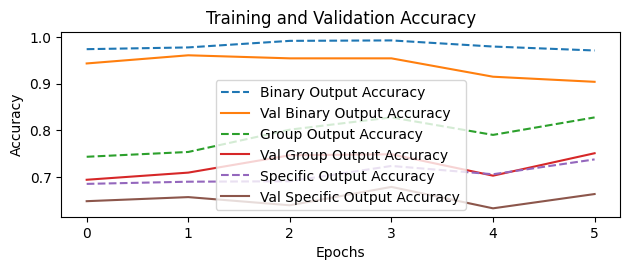

In [ ]:
import matplotlib.pyplot as plt
# Plot loss
# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(binary_acc, linestyle='--', label='Binary Output Accuracy')
plt.plot(val_binary_acc, label='Val Binary Output Accuracy')
plt.plot(group_acc, linestyle='--', label='Group Output Accuracy')
plt.plot(val_group_acc, label='Val Group Output Accuracy')
plt.plot(specific_acc, linestyle='--', label='Specific Output Accuracy')
plt.plot(val_specific_acc, label='Val Specific Output Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


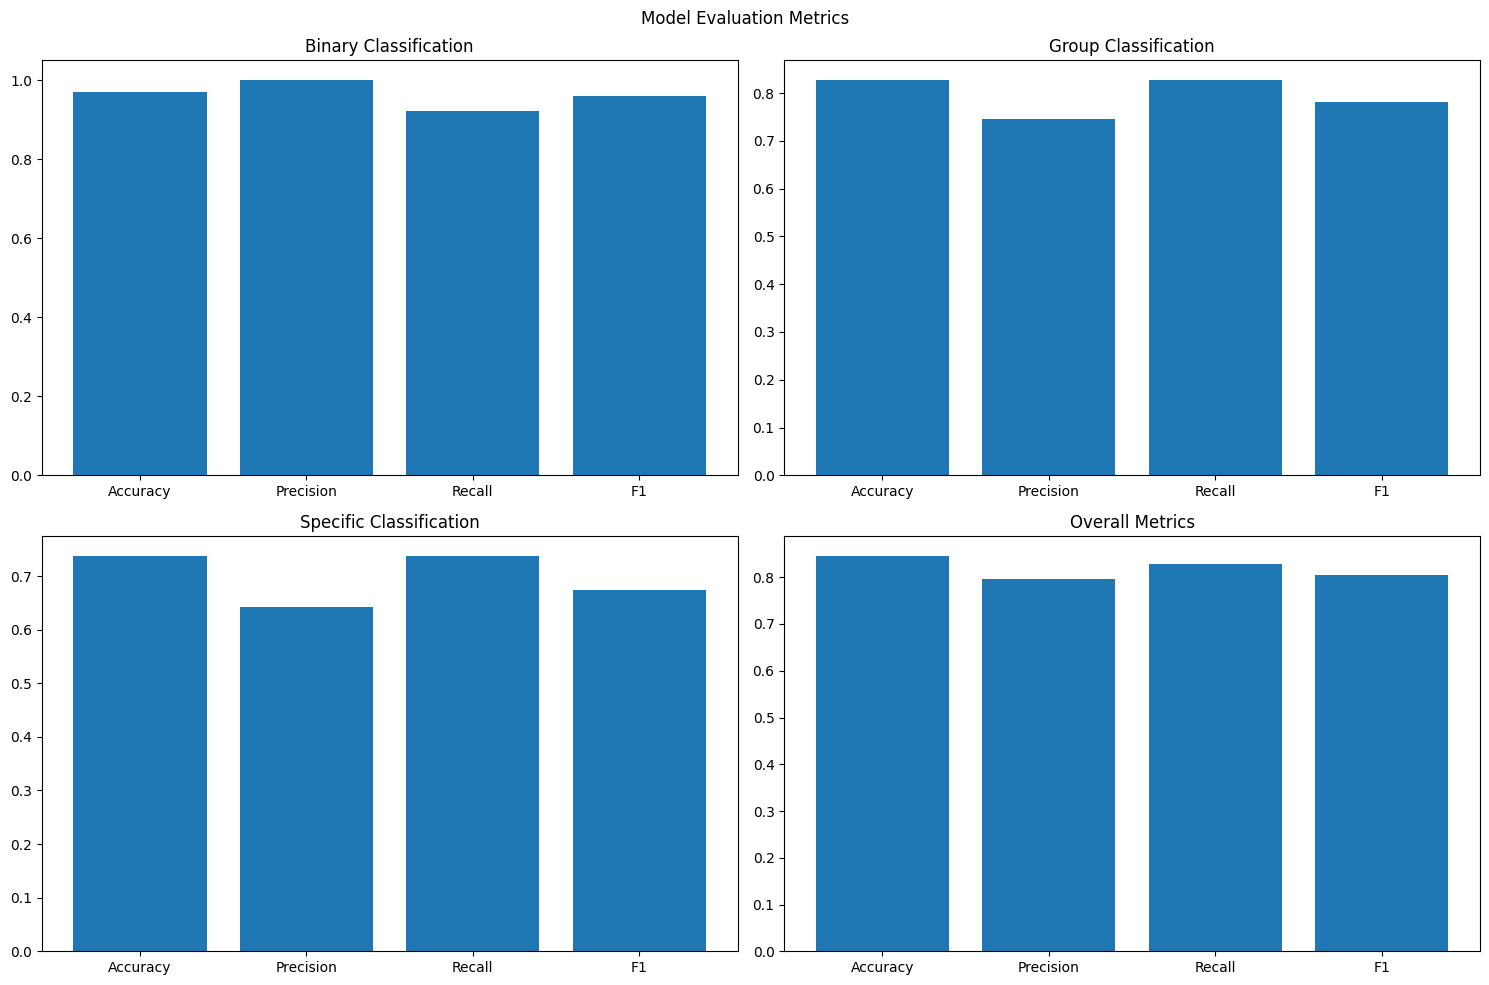

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics
def plot_metrics(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Evaluation Metrics')

    # Binary Classification Metrics
    axes[0, 0].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['binary_accuracy'], metrics['binary_precision'], metrics['binary_recall'], metrics['binary_f1']])
    axes[0, 0].set_title('Binary Classification')

    # Group Classification Metrics
    axes[0, 1].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['group_accuracy'], metrics['group_precision'], metrics['group_recall'], metrics['group_f1']])
    axes[0, 1].set_title('Group Classification')

    # Specific Classification Metrics
    axes[1, 0].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['specific_accuracy'], metrics['specific_precision'], metrics['specific_recall'], metrics['specific_f1']])
    axes[1, 0].set_title('Specific Classification')

    # Overall Metrics
    overall_accuracy = (metrics['binary_accuracy'] + metrics['group_accuracy'] + metrics['specific_accuracy']) / 3
    overall_precision = (metrics['binary_precision'] + metrics['group_precision'] + metrics['specific_precision']) / 3
    overall_recall = (metrics['binary_recall'] + metrics['group_recall'] + metrics['specific_recall']) / 3
    overall_f1 = (metrics['binary_f1'] + metrics['group_f1'] + metrics['specific_f1']) / 3

    axes[1, 1].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [overall_accuracy, overall_precision, overall_recall, overall_f1])
    axes[1, 1].set_title('Overall Metrics')

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)